### Question: Do the model-fitting parameters find the optimum sample size?

We built the model on the assumption that a certain "sweet spot" existed in the corpus, a specific sample size that, when drawn, would exhibit a "perfect Zipf distribution". Even if it isn't "perfect", is it at least the "most perfect" sample size? Can we distill the essence of "Zipfiness" down to a single metric, maximize that metric over sample size, and determine if the _model-fitting parameter $M_z$_ independently corresponds to the _optimum sample size $M_z$_?

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd

# custom classes
from legomena import Corpus, SPGC, LogModel

In [2]:
# standard project gutenberg corpus
spgc = SPGC.getMeta()

# for now, restrict study to english-only
spgc = spgc[spgc.language == "['en']"]

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


### Choosing a Book

Select a book for use as our fitting corpus.

Optimum (M_z,N_z) = LogParams(M_z=112292, N_z=12203)


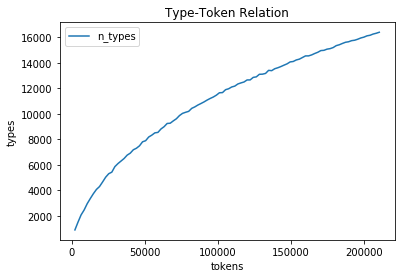

In [3]:
# spgc[spgc.title.str.contains("Bible", na = False)].head()

# moby dick
corpus = SPGC.get(2701)
TTR = corpus.TTR
model = LogModel().fit(TTR.m_tokens, TTR.n_types)
print("Optimum (M_z,N_z) =", model.params)

# plot TTR curve
plt.plot(TTR.m_tokens, TTR.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

### Is the Optimum Sample Zipf-Distributed?

Ok, we've determined that better fitting parameters can be found by minimizing the mean-squared error of 100 predictions using a stochastic process. That's not all that surprising. The question now is:

- Does the stochastic solution fall inside the confidence interval of the theoretical solution? Vice versa?
- Does a sampled corpus of size $M_z$ follow a perfect Zipf distribution?

Optimum (M_z,N_z) = LogParams(M_z=112292, N_z=12203)


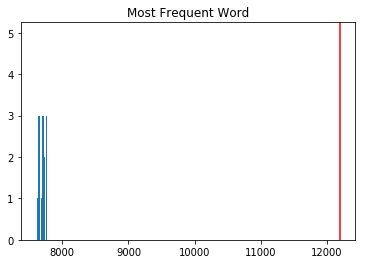

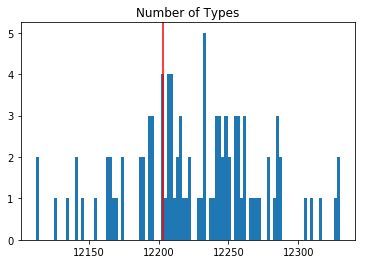

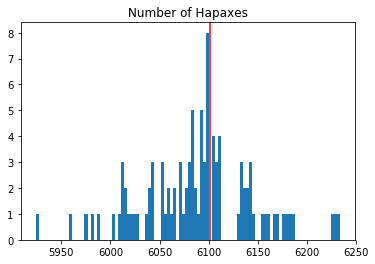

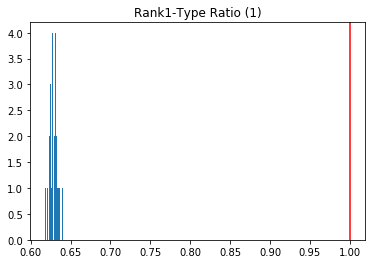

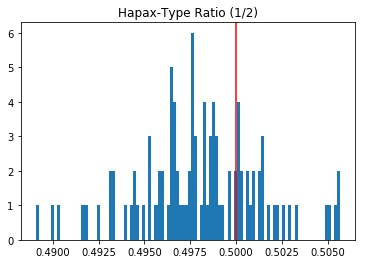

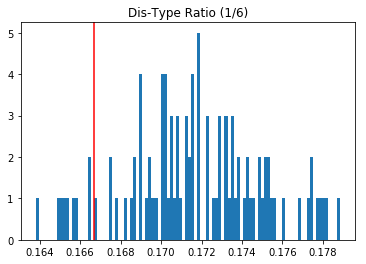

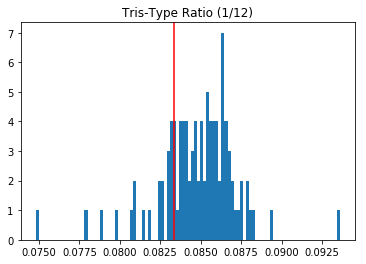

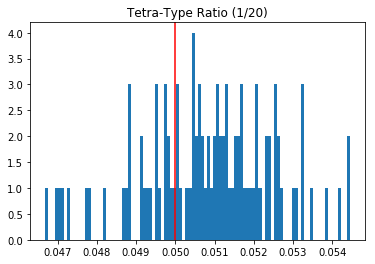

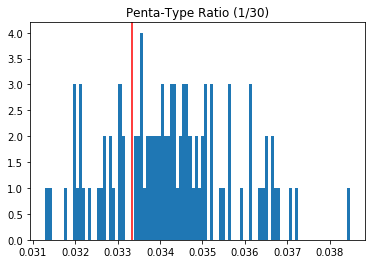

,types,hapax,dis,tris,tetra,penta,rank1,rank1_frac,hapax_frac,dis_frac,tris_frac,tetra_frac,penta_frac
0,12269,6136,2073,1028,605,430,7653,0.623767,0.500122,0.168962,0.083788,0.049311,0.035048
1,12242,6081,2146,1059,577,400,7730,0.631433,0.496733,0.175298,0.086505,0.047133,0.032674
2,12288,6140,2104,1040,654,406,7673,0.624430,0.499674,0.171224,0.084635,0.053223,0.033040
3,12223,6098,2096,1015,617,423,7716,0.631269,0.498896,0.171480,0.083040,0.050479,0.034607
4,12330,6234,2035,1078,601,452,7625,0.618410,0.505596,0.165045,0.087429,0.048743,0.036659


In [4]:
# build mini-corpus around optimal value
np.random.seed(42)
M_z, N_z = model.params
print("Optimum (M_z,N_z) =", model.params)

df = []
for _ in range(99):
    minicorpus = corpus.sample(M_z)
    rank1 = len(minicorpus.k) # observed frequency of most frequent token
    types = minicorpus.N      # observed number of types
    hapax = minicorpus.k[1]   # observed number of hapax legomena
    dis   = minicorpus.k[2]   # observed number of dis   legomena
    tris  = minicorpus.k[3]   # observed number of tris  legomena
    tetra = minicorpus.k[4]   # observed number of tetra legomena
    penta = minicorpus.k[5]   # observed number of penta legomena
    df.append((types, hapax, dis, tris, tetra, penta, rank1))

# distributions of counts & ratios
df = pd.DataFrame(df, columns = ["types", "hapax", "dis", "tris", "tetra", "penta", "rank1"])
df["rank1_frac"] = df.rank1 / df.types
df["hapax_frac"] = df.hapax / df.types
df["dis_frac"]   = df.dis   / df.types
df["tris_frac"]  = df.tris  / df.types
df["tetra_frac"] = df.tetra / df.types
df["penta_frac"] = df.penta / df.types

plt.hist(df.rank1, bins = 100); plt.axvline(x = N_z, color = "red"); plt.title("Most Frequent Word"); plt.show()
plt.hist(df.types, bins = 100); plt.axvline(x = N_z, color = "red"); plt.title("Number of Types"); plt.show()
plt.hist(df.hapax, bins = 100); plt.axvline(x = N_z/2, color = "red"); plt.title("Number of Hapaxes"); plt.show()
plt.hist(df.rank1_frac, bins = 100); plt.axvline(x = 1, color = "red"); plt.title("Rank1-Type Ratio (1)"); plt.show()
plt.hist(df.hapax_frac, bins = 100); plt.axvline(x = 1/2, color = "red"); plt.title("Hapax-Type Ratio (1/2)"); plt.show()
plt.hist(df.dis_frac, bins = 100); plt.axvline(x = 1/6, color = "red"); plt.title("Dis-Type Ratio (1/6)"); plt.show()
plt.hist(df.tris_frac, bins = 100); plt.axvline(x = 1/12, color = "red"); plt.title("Tris-Type Ratio (1/12)"); plt.show()
plt.hist(df.tetra_frac, bins = 100); plt.axvline(x = 1/20, color = "red"); plt.title("Tetra-Type Ratio (1/20)"); plt.show()
plt.hist(df.penta_frac, bins = 100); plt.axvline(x = 1/30, color = "red"); plt.title("Penta-Type Ratio (1/30)"); plt.show()

# recap
df.head()

Sure doesn't look like it... Let's see if we can devise a simple statistical test to collapse these plots down to a single metric. Here we take samples of a variety of sizes (20%-80% the corpus size) and use two goodness-of-fit tests to see how "Zipfian" the samples are: chi-squared and system stability index. Then ask the question: Does the model fit for $M_z$ coincide with the "most Zipfian", i.e. _optimum_ sample size, as hypothesized?

In [5]:
# bloody dependencies
from scipy.stats import chisquare
import powerlaw
def ssi_test(f_obs, f_exp):
    assert all(f_obs >= 0)
    assert all(f_exp >= 0)
    nonzero = (f_obs > 0) & (f_exp > 0)
    f_obs = f_obs[nonzero]
    f_exp = f_exp[nonzero]
    f_obs = f_obs / f_obs.sum()
    f_exp = f_exp / f_exp.sum()
    return np.sum((f_obs - f_exp) * np.log(f_obs / f_exp))
    
# build mini-corpus around optimal value
np.random.seed(42)
print("Optimum (M_z,N_z) =", model.params)

# only look at n < 40
# NOTE: slight cheat, but the higher the n, the more 0s & 1s, i.e.
#       sparse data screws up the chi-square test
NMAX = 40 # len(minicorpus.k))

results = []
for _ in range(99):
    x = np.random.uniform(0.2, 0.8)
    minicorpus = corpus.sample(x=x)

    # expected n-legomena counts
    x = np.arange(1, NMAX)
    k_exp = N_z/x/(x+1)
    k_obs = minicorpus.k[x]
    # print("Expected:", k_exp)
    # print("Observed:", k_obs)

    # chi-squared test
    chi2 = chisquare(k_obs, k_exp)
    # print("Chi-square:", chi2)

    # SSI test
    ssi = ssi_test(k_obs, k_exp)
    # print("SSI:", ssi)
    
    # clauset
    data = minicorpus.fdist.freq.values
    plaw = powerlaw.Fit(data, discrete = True, verbose = False).power_law
    
    # append results
    results.append((M, chi2.statistic, chi2.pvalue, ssi, plaw.alpha, plaw.xmin))

# results
df = pd.DataFrame(results, columns=["tokens", "chi2.stat", "chi2.pval", "ssi", "alpha", "xmin"])
df.head()

Optimum (M_z,N_z) = LogParams(M_z=112292, N_z=12203)


/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


,tokens,chi2.stat,chi2.pval,ssi,alpha,xmin
0,89301,193.502809,1.011734e-22,0.006448,1.941352,3.0
1,154414,447.398736,2.357613e-71,0.006846,1.941926,5.0
2,140813,238.567793,6.887963e-31,0.004029,1.936682,4.0
3,64693,840.579593,8.071617e-152,0.019779,1.924353,8.0
4,165777,682.557304,3.959549e-119,0.008847,1.935387,5.0


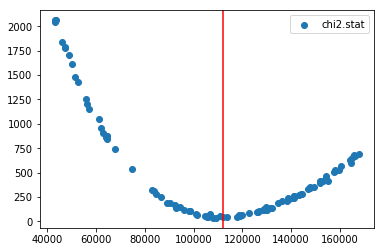

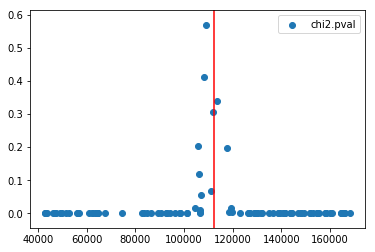

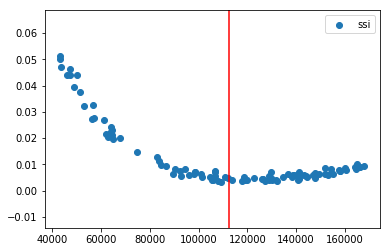

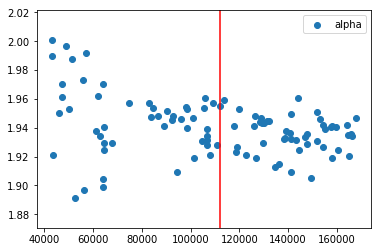

In [6]:
# chi-squared
plt.scatter(df.tokens, df["chi2.stat"])
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()

# chi-squared
plt.scatter(df.tokens, df["chi2.pval"])
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()

# system stability
plt.scatter(df.tokens, df.ssi)
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()

# clauset
plt.scatter(df.tokens, df.alpha)
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()

That would be an emphatic _yes_. In fact, it's slightly surprising just how strong the signal is. It's always spooky to see _language_, particularly a _random permutation of language_ obey neat and tidy physical laws.

A caveat here: We introduced a hyperparameter `NMAX` and only looked at n-legomena counts _up to_ `NMAX`. This is because $\vec{k}$ is extremely sparse: $k_n \propto \frac{1}{n(n+1)}$. Lots of _expected_ "counts" on the order of the thousandths translate to _observed_ counts of a 1 amidst a sea of 0s, which screws up the chi-square test. Still, as long as this hyperparameter is chosen in advance, the test above is comparing apples to apples and finding a true minimum.

### Rank-Frequency Relation

But the above just looked at n-legomena counts, a concept nearly absent from the literature. What about the much more popular rank-frequency relation? Let's run the same little experiment again, applying the same two tests on the rank-frequency distribution.

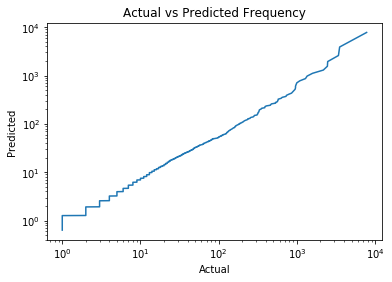

,type,freq,zipf
rank,,,
1,the,7782,7782.000000
2,of,3517,3891.000000
3,and,3394,2594.000000
4,a,2474,1945.500000
5,to,2452,1556.400000
6,in,2175,1297.000000
7,that,1583,1111.714286
8,his,1349,972.750000
9,it,1286,864.666667


In [7]:
# how well do they agree at all?
minicorpus = corpus.sample(M_z)
df = minicorpus.fdist
N = df.freq.max()
df["zipf"] = N / df.index

# actual vs predicted
plt.loglog(df.freq, df.zipf);
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Frequency")
plt.show()

# most frequent words
df.head(10)

Although the actual vs predicted scatterplot looks "sort of" linear, a quick glance at the most frequent words and one can easily see the distribution is not harmonic. Not even close. Only by accumulating lots of data does the log-log linearity emerge. Ironically, the most frequent words seem more like _exceptions_ to Zipf's law, despite it usually being framed in their terms: "of appearing half as often as the" for example. Let's roll with the optimum sample size $M_z$ and see how consistent the data is.

Optimum (M_z,N_z) = LogParams(M_z=112292, N_z=12203)


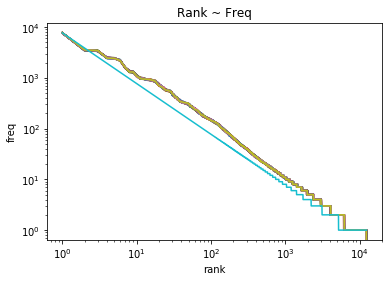

In [8]:
# build mini-corpus around optimal value
np.random.seed(42)
print("Optimum (M_z,N_z) =", model.params)

for _ in range(99):
    minicorpus = corpus.sample(M_z)

    # expected n-legomena counts
    df = minicorpus.fdist
    N = df.freq.max() # rank 1 frequency
    x_rank = np.array(df.index)
    f_exp = np.round(N/x_rank)
    f_obs = df.freq.values
    # print("Expected:", f_exp)
    # print("Observed:", f_obs)

    # plot
    plt.loglog(x_rank, f_obs)

# finish plot
plt.loglog(x_rank, f_exp)
plt.xlabel("rank")
plt.ylabel("freq")
plt.title("Rank ~ Freq")
plt.show()

Pretty remarkably consistent! The plot is indeed "sort of" log-linear, implying Zipf's law, but one would be tempted to chalk up the deviations to noise. Actually, taking samples of the exact same size over and over again the plots overlay and reinforce each other to a remarkable degree, indicating that, far from being noise, these deviations from log-linearity are very much signal. A signal of what? This underlying word frequency distribution is obviously a built-in feature of _this-sized sample_ of _this book_ by _this author_ in _this language_, but how high up the chain does it go? Does the pattern deteriorate given variable sample sizes?

Optimum (M_z,N_z) = LogParams(M_z=112292, N_z=12203)


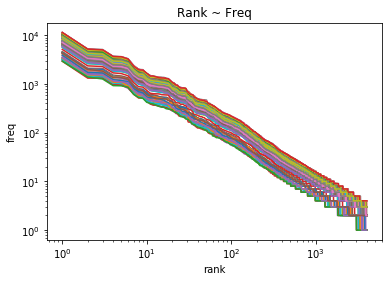

In [9]:
# build mini-corpus around range of values
np.random.seed(42)
print("Optimum (M_z,N_z) =", model.params)

# only look at n < 4000
# NOTE: only evaluate the NMAX most frequent words
NMAX = 4000 # len(minicorpus.k))

results = []
for _ in range(99):
    x = np.random.uniform(0.2, 0.8)
    minicorpus = corpus.sample(x=x)

    # expected n-legomena counts
    df = minicorpus.fdist.head(NMAX)
    x_rank = np.array(df.index)
    N = df.freq.max() # rank 1 frequency
    f_exp = np.round(N/x_rank)
    f_obs = df.freq.values
    # print("Expected:", f_exp)
    # print("Observed:", f_obs)

    # plot
    plt.loglog(x_rank, f_obs)

    # chi-squared test
    from scipy.stats import chisquare
    chi2 = chisquare(f_obs, f_exp)
    # print("Chi-square:", chi2)

    # SSI test
    def ssi_test(f_obs, f_exp):
        assert all(f_obs >= 0)
        assert all(f_exp >= 0)
        nonzero = (f_obs > 0) & (f_exp > 0)
        f_obs = f_obs[nonzero]
        f_exp = f_exp[nonzero]
        f_obs = f_obs / f_obs.sum()
        f_exp = f_exp / f_exp.sum()
        return np.sum((f_obs - f_exp) * np.log(f_obs / f_exp))

    ssi = ssi_test(f_obs, f_exp)
    # print("SSI:", ssi)
    
    results.append((M, chi2.statistic, chi2.pvalue, ssi))

# results
df = pd.DataFrame(results, columns = ["tokens", "chi2.stat", "chi2.pval", "ssi"])
df.head()

# finish plot
# plt.loglog(x_rank, f_exp)
plt.xlabel("rank")
plt.ylabel("freq")
plt.title("Rank ~ Freq")
plt.show()

No. On the contrary, _regardless of sample size_ the same pattern is reinforced. In fact, these colored bands are formed by the nearly identically-shaped plot layering from the lower-left to the upper right in this "rainbow" pattern. Therefore this pattern, these _deviations_ from Zipf's law, must at least be an innate property of _this book_ if not this author/language. Interesting as this is, it renders completely useless the prospect of using a chi-square or system stability test to determine _which_ of these bands is the "most Zipfian." It's readily apparent from the plot that they are _all_ equally "Zipfian". Yet none are _exactly_ Zipfian, not for $\alpha = 1$ or otherwise (no best-fit line is going to capture these irregularities).

Question for future study: Do these sample-size-independent irregularities persist across books by the same author? Across authors writing in the same language?

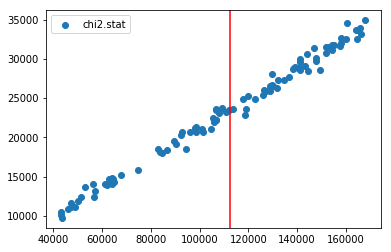

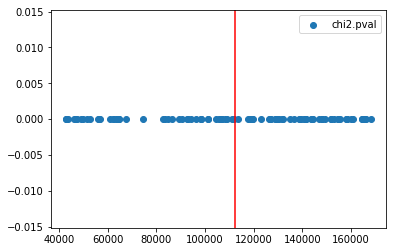

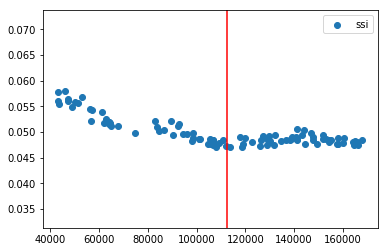

In [10]:
# chi-squared
plt.scatter(df.tokens, df["chi2.stat"])
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()
plt.scatter(df.tokens, df["chi2.pval"])
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()

# system stability
plt.scatter(df.tokens, df.ssi)
plt.axvline(x = M_z, color = "red")
plt.legend()
plt.show()

SSI _may_ imply a fairly weak signal, but the more sensitive chi-square tolerates nothing here.

### Conclusion

The first and most remarkable conclusion is that although the frequency distribution of _common to medium_ words is not strictly Zipfian, they are quite self-consistent. Since their distribution does not appear log-linear anyway, we're not going to bother searching the fringes with a generalization exponent. Bottom line is that the WFD just isn't log-linear without a dubious amount of squinting, although a fairly weak case can be made (SSI test) that the model-fitting parameter $M_z$ defines the _most_ log-linear sample.

The more practical result is that the two definitions of $M_z$ agree perfectly: as a model-fitting parameter of the vocabulary growth curve, and as the optimal size for drawing the "most Zipfian" sample.

### Further Study

The word frequency distribution seems to line up peculiarly well regardless of the sample size. This makes sense for common words, since the discretized Bernoulli distribution is smoother for large frequencies. But it doesn't make as much sense across scales. Can the WFD be used to "fingerprint" a work?

- At the book level? Yes, samples of varying sizes are remarkably similar in WFD
- At the author level?
- At the language level?